In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data
from loss import create_loss
from network import init_net_orth, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd

In [2]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

loss_fn = create_loss(target)
e2e_loss_fn = compose(loss_fn, compute_end_to_end)

In [3]:
depth = 3
init_type = "orth"
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net_orth(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-10
step_size = 1e3
n_outer_loops = 5000
n_inner_loops = 200

In [4]:
orig_step_size = step_size
orig_result = train(
    init_weights=init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=orig_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
V = compute_factor(init_weights=init_weights, e2e_loss_fn=e2e_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=r)

In [6]:
prop = 0
comp_step_size = [prop * step_size] + (depth * [step_size]) + [prop * step_size]
comp_result = train(
    init_weights=comp_init_weights,
    train_e2e_loss_fn=e2e_loss_fn,
    n_outer_loops=n_outer_loops,
    step_size=comp_step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
orig_weights = orig_result['weights']
comp_weights = comp_result['weights']
orig_end_to_end = [compute_output(w).reshape(-1) for w in orig_weights]
comp_end_to_end = [compute_output(w).reshape(-1) for w in comp_weights]

In [8]:
key, subkey = split(key)
A = jnp.linalg.svd(generate_data(key=subkey, shape=(2, d*d)), full_matrices=False)[2]

In [9]:
red_orig_end_to_end = jnp.array([A @ w for w in orig_end_to_end])
red_comp_end_to_end = jnp.array([A @ w for w in comp_end_to_end])

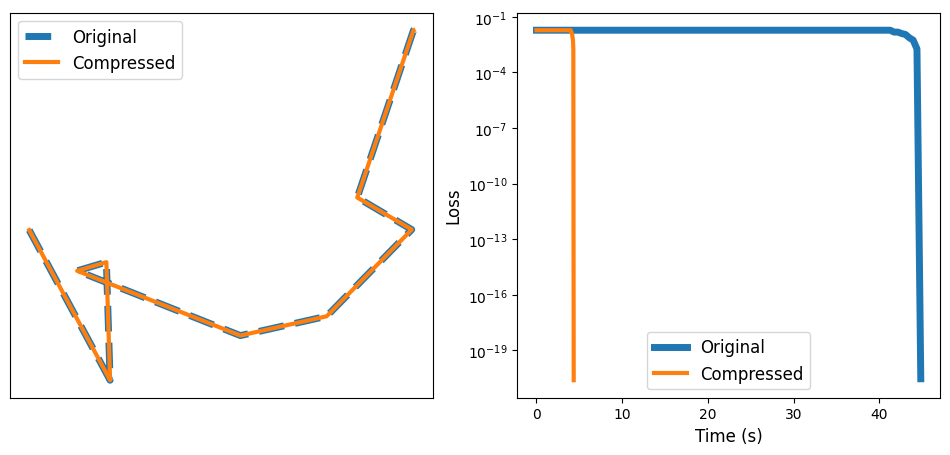

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 5))

axes[0].plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], linewidth=5, linestyle='--', label='Original')
axes[0].plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], linewidth=3, linestyle='-', label='Compressed')
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[0].yaxis.set_tick_params(labelleft=False)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].legend(fontsize=12)

axes[1].semilogy(orig_result['time'], orig_result['train_loss'], linewidth=5, label='Original')
axes[1].semilogy(comp_result['time'], comp_result['train_loss'], linewidth=3, label='Compressed')
axes[1].set_xlabel('Time (s)', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=12)


plt.savefig('figs/equiv_traj_l2.png', dpi=300, bbox_inches='tight')